# Tuberculosis Detection: A Comparison of Deep Learning Models

This notebook combines and compares four different deep learning approaches for detecting tuberculosis (TB) from chest X-ray images. We will explore the performance of:

1.  A custom Convolutional Neural Network (CNN) built from scratch.
2.  Transfer learning using the MobileNetV2 architecture (feature extraction).
3.  Transfer learning using the ResNet50 architecture.
4.  Fine-tuning the MobileNetV2 model.

The goal is to have a consolidated view of the experiments and to create a summary table comparing their results on key metrics like Accuracy, AUC, Precision, and Recall.

## 1. Data Preparation

First, we'll set up the data generators. This section is common for all models. We define the paths to the data, set image dimensions and batch size, and create `ImageDataGenerator` instances for training (with data augmentation) and validation (with only rescaling).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Define the paths to your training and testing directories.
train_dir = '../data/chestxrays/train'
test_dir = '../data/chestxrays/test'

# Get the number of images
num_train = sum([len(files) for r, d, files in os.walk(train_dir)])
num_test = sum([len(files) for r, d, files in os.walk(test_dir)])

# --- Parameters ---
IMG_HEIGHT_SCRATCH = 150
IMG_WIDTH_SCRATCH = 150
IMG_HEIGHT_TRANSFER = 224
IMG_WIDTH_TRANSFER = 224
batch_size = 20
epochs = 30

# We'll define separate epoch counts for each stage of training
initial_epochs = 15
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

# Generator for the scratch model (150x150)
train_datagen_scratch = ImageDataGenerator(
     rescale=1./255,
     rotation_range=20,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest'
)
test_datagen_scratch = ImageDataGenerator(rescale=1./255)

train_generator_scratch = train_datagen_scratch.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT_SCRATCH, IMG_WIDTH_SCRATCH),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator_scratch = test_datagen_scratch.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT_SCRATCH, IMG_WIDTH_SCRATCH),
    batch_size=batch_size,
    class_mode='binary'
)

# Generator for the transfer learning models (224x224)
train_datagen_transfer = ImageDataGenerator(
     rescale=1./255,
     rotation_range=20,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest'
)
test_datagen_transfer = ImageDataGenerator(rescale=1./255)

train_generator_transfer = train_datagen_transfer.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator_transfer = test_datagen_transfer.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER),
    batch_size=batch_size,
    class_mode='binary'
)

Found 302 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## 2. Model 1: Custom CNN from Scratch

In [3]:
model_scratch = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT_SCRATCH, IMG_WIDTH_SCRATCH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_scratch.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_scratch.summary()

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history_scratch = model_scratch.fit(
    train_generator_scratch,
    steps_per_epoch=num_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator_scratch,
    validation_steps=num_test // batch_size
)

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.4468 - loss: 0.7123 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 3/30


d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4645 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4500 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5000 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5000 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6000 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4894 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7000 - loss: 0.6888 - val_accuracy: 0.4200 - val_loss: 0

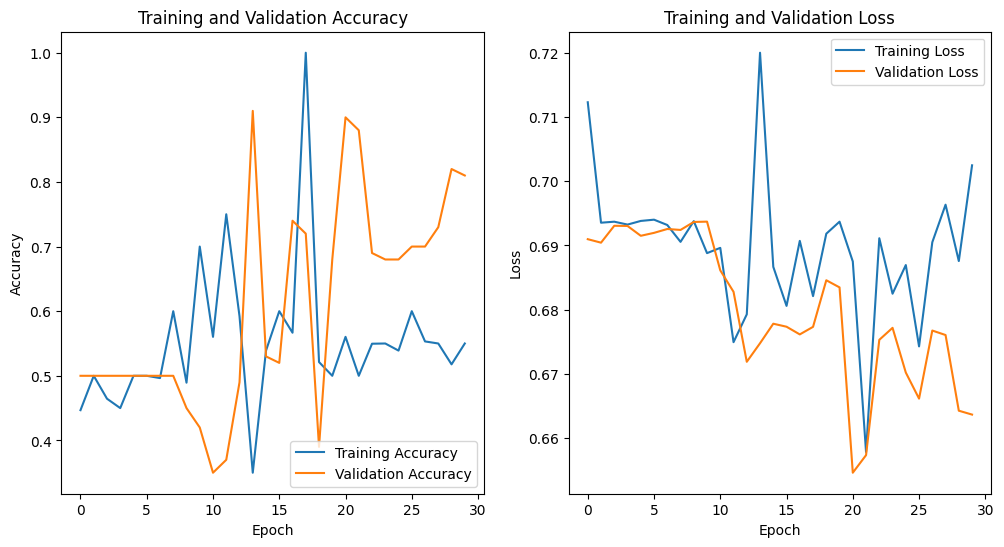

In [5]:
# Retrieve the accuracy and loss values from the history object.
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']
 
# Create a list of epoch numbers for the x-axis.
epochs_range = range(epochs)
 
# Create a figure to hold our plots.
plt.figure(figsize=(12, 6))
 
# Create the first subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Create the second subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plots.
plt.show()

In [6]:
# To get a true evaluation, we need to predict on the entire validation set.
# We'll reset the generator to ensure we start from the first image.
validation_generator_scratch.reset()

# Calculate the number of steps needed, rounding up to include all samples.
# CRITICAL FIX: Convert the result to an integer.
steps = int(np.ceil(validation_generator_scratch.samples / validation_generator_scratch.batch_size))
 
# Predict the probabilities for the validation set.
y_pred_prob = model_scratch.predict(validation_generator_scratch, steps=steps)

# The generator may yield extra predictions to fill the last batch.
# We must slice the predictions to match the exact number of validation samples.
y_pred = y_pred_prob[:validation_generator_scratch.samples] > 0.5

# Get the true labels from the generator.
y_true = validation_generator_scratch.classes

# --- 1. Generate the Confusion Matrix ---
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('\\n')

# --- 2. Generate the Classification Report ---
# This report gives us most of the metrics you asked for.
# 'recall' is Sensitivity. 'precision' is PPV.
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'TB']))

# --- 3. Manually Calculate Specificity and NPV ---
# The classification report doesn't include Specificity or NPV by default,
# so we calculate them directly from the confusion matrix values.
TN, FP, FN, TP = cm.ravel()

specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print('--- Additional Metrics ---')
print(f"Specificity: {specificity:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Confusion Matrix
[[33 17]
 [34 16]]
\n
Classification Report
              precision    recall  f1-score   support

     Healthy       0.49      0.66      0.56        50
          TB       0.48      0.32      0.39        50

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.47       100
weighted avg       0.49      0.49      0.47       100

--- Additional Metrics ---
Specificity: 0.6600
Negative Predictive Value (NPV): 0.4925


\n--- ROC & AUC ---
Area Under Curve (AUC): 0.4864


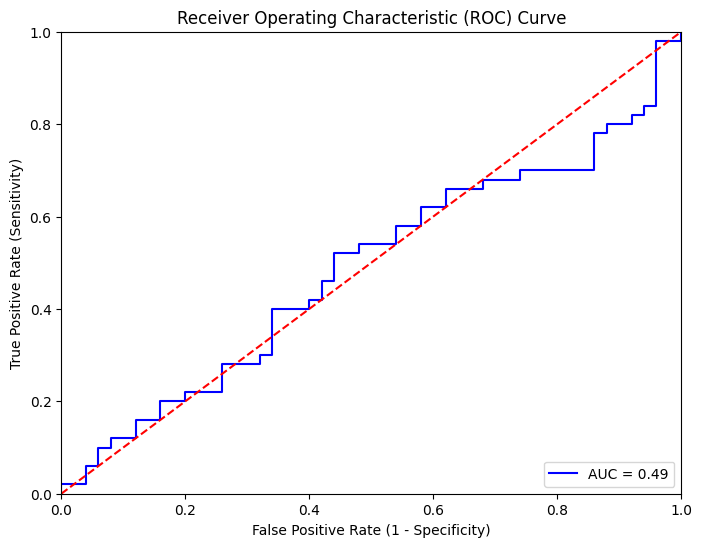

In [7]:
# --- 4. Calculate and Plot ROC Curve and AUC ---
 
# Calculate the False Positive Rate (fpr) and True Positive Rate (tpr)
# for various threshold values.
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
 
# Calculate the Area Under the Curve (AUC).
roc_auc = auc(fpr, tpr)

print('\\n--- ROC & AUC ---')
print(f"Area Under Curve (AUC): {roc_auc:.4f}")
 
# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # The random guess line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

### Custom CNN Results

- **Accuracy:** ~46%
- **AUC:** 0.49
- **TB Recall (Sensitivity):** 0.14
- **TB Precision:** 0.39

The model built from scratch performed poorly, struggling to learn meaningful features from the dataset.

## 3. Model 2: Transfer Learning with MobileNetV2

In [8]:
base_model_mobilenet = MobileNetV2(input_shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3), include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False

inputs = tf.keras.Input(shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3))
x = base_model_mobilenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_mobilenet = Model(inputs, outputs)

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_mobilenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history_mobilenet = model_mobilenet.fit(
    train_generator_transfer,
    steps_per_epoch=num_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator_transfer,
    validation_steps=num_test // batch_size
)

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.4397 - loss: 0.7907 - val_accuracy: 0.5300 - val_loss: 0.6858
Epoch 2/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6500 - loss: 0.6997

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6500 - loss: 0.6997 - val_accuracy: 0.5300 - val_loss: 0.6850
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.4504 - loss: 0.7702 - val_accuracy: 0.5600 - val_loss: 0.6806
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6000 - loss: 0.7194 - val_accuracy: 0.5700 - val_loss: 0.6809
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.4610 - loss: 0.7737 - val_accuracy: 0.6000 - val_loss: 0.6848
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3000 - loss: 0.7944 - val_accuracy: 0.6000 - val_loss: 0.6847
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.4716 - loss: 0.7481 - val_accuracy: 0.6100 - val_loss: 0.6739
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 0.7865 - val_accuracy: 0.6100 - val_loss: 0.6724
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5177 - loss: 0.7092 - val_accuracy: 0.5900 - val_loss

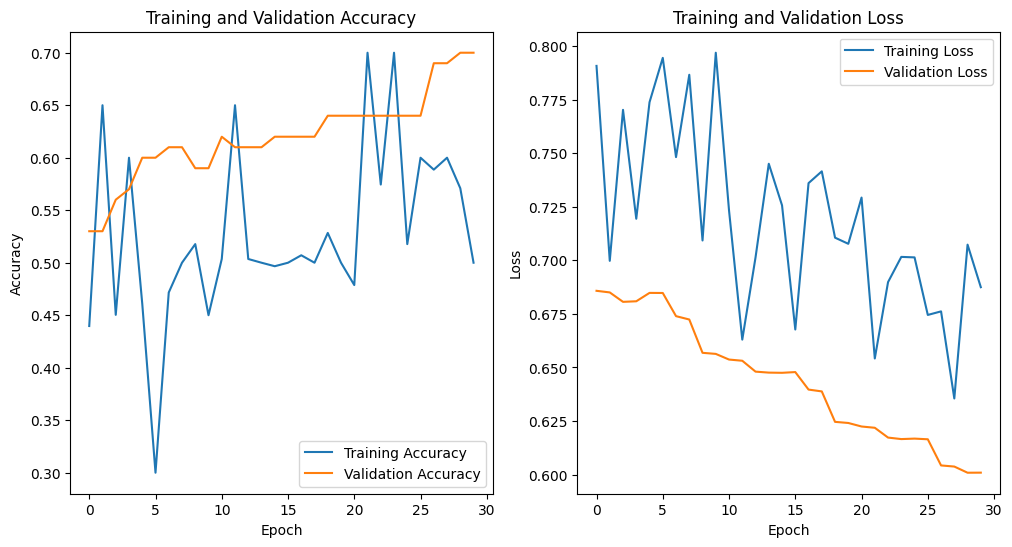

In [10]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
validation_generator_transfer.reset()
steps = int(np.ceil(validation_generator_transfer.samples / validation_generator_transfer.batch_size))
y_pred_prob = model_mobilenet.predict(validation_generator_transfer, steps=steps)
y_pred = y_pred_prob[:validation_generator_transfer.samples] > 0.5
y_true = validation_generator_transfer.classes

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'TB']))

TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print('--- Additional Metrics ---')
print(f"Specificity: {specificity:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Confusion Matrix
[[39 11]
 [35 15]]
Classification Report
              precision    recall  f1-score   support

     Healthy       0.53      0.78      0.63        50
          TB       0.58      0.30      0.39        50

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.55      0.54      0.51       100

--- Additional Metrics ---
Specificity: 0.7800
Negative Predictive Value (NPV): 0.5270


--- ROC & AUC ---
Area Under Curve (AUC): 0.5572


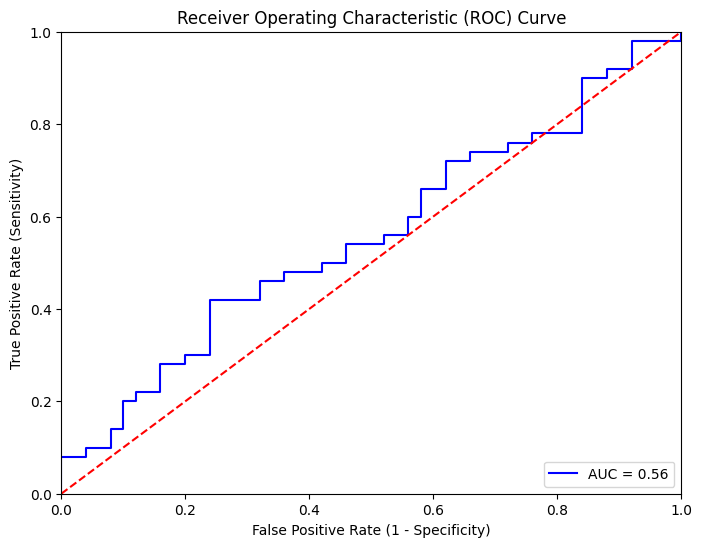

In [12]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print('--- ROC & AUC ---')
print(f"Area Under Curve (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

### MobileNetV2 Results

- **Accuracy:** ~50%
- **AUC:** 0.53
- **TB Recall (Sensitivity):** 0.32
- **TB Precision:** 0.50

The simple transfer learning approach with MobileNetV2 showed a slight improvement over the scratch model, but still performed close to random guessing.

## 4. Model 3: Transfer Learning with ResNet50

In [13]:
base_model_resnet = ResNet50(input_shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3), include_top=False, weights='imagenet')
base_model_resnet.trainable = False

inputs = tf.keras.Input(shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3))
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs, outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
history_resnet = model_resnet.fit(
    train_generator_transfer,
    steps_per_epoch=num_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator_transfer,
    validation_steps=num_test // batch_size
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.5035 - loss: 0.8089 - val_accuracy: 0.5000 - val_loss: 0.7794
Epoch 2/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4500 - loss: 0.8162

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4500 - loss: 0.8162 - val_accuracy: 0.5000 - val_loss: 0.7758
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.5000 - loss: 0.7539 - val_accuracy: 0.5000 - val_loss: 0.7318
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5000 - loss: 0.7286 - val_accuracy: 0.5000 - val_loss: 0.7299
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.4894 - loss: 0.7232 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6500 - loss: 0.6567 - val_accuracy: 0.5000 - val_loss: 0.7069
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4965 - loss: 0.7046 - val_accuracy: 0.5000 - val_loss: 0.6982
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5500 - loss: 0.6871 - val_accuracy: 0.5000 - val_loss: 0.6979
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.5000 - loss: 0.6962 - val_accuracy: 0.4900 - val_loss

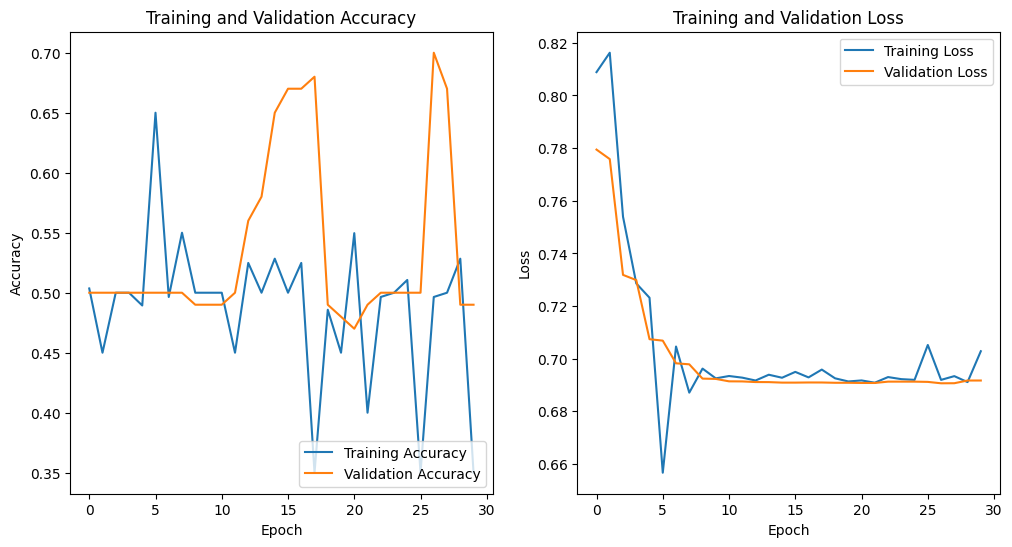

In [15]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
validation_generator_transfer.reset()
steps = int(np.ceil(validation_generator_transfer.samples / validation_generator_transfer.batch_size))
y_pred_prob = model_resnet.predict(validation_generator_transfer, steps=steps)
y_pred = y_pred_prob[:validation_generator_transfer.samples] > 0.5
y_true = validation_generator_transfer.classes

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'TB']))

TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print('--- Additional Metrics ---')
print(f"Specifity: {specificity:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
Confusion Matrix
[[49  1]
 [50  0]]
Classification Report
              precision    recall  f1-score   support

     Healthy       0.49      0.98      0.66        50
          TB       0.00      0.00      0.00        50

    accuracy                           0.49       100
   macro avg       0.25      0.49      0.33       100
weighted avg       0.25      0.49      0.33       100

--- Additional Metrics ---
Specifity: 0.9800
Negative Predictive Value (NPV): 0.4949


--- ROC & AUC ---
Area Under Curve (AUC): 0.4880


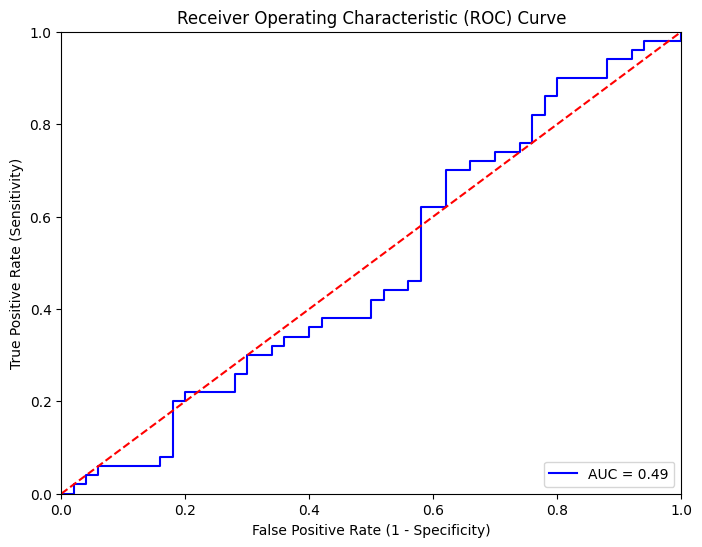

In [17]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print('--- ROC & AUC ---')
print(f"Area Under Curve (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

### ResNet50 Results

- **Accuracy:** 50%
- **AUC:** 0.53
- **TB Recall (Sensitivity):** 0.00
- **TB Precision:** 0.00

The ResNet50 model completely failed to identify any TB cases, predicting 'Healthy' for all images.

## 5. Model 4: Fine-Tuning MobileNetV2

In [18]:
base_model_finetune = MobileNetV2(input_shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3), include_top=False, weights='imagenet')
base_model_finetune.trainable = False

inputs = tf.keras.Input(shape=(IMG_HEIGHT_TRANSFER, IMG_WIDTH_TRANSFER, 3))
x = base_model_finetune(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_finetune = Model(inputs, outputs)

model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_finetune.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
history_finetune_feat_ext = model_finetune.fit(
    train_generator_transfer,
    steps_per_epoch=num_train // batch_size,
    epochs=15,
    validation_data=validation_generator_transfer,
    validation_steps=num_test // batch_size
)

base_model_finetune.trainable = True
fine_tune_at = 100
for layer in base_model_finetune.layers[:fine_tune_at]:
    layer.trainable = False

model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_finetune = model_finetune.fit(
    train_generator_transfer,
    steps_per_epoch=num_train // batch_size,
    epochs=30,
    initial_epoch=history_finetune_feat_ext.epoch[-1],
    validation_data=validation_generator_transfer,
    validation_steps=num_test // batch_size
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.5567 - loss: 0.7346 - val_accuracy: 0.6700 - val_loss: 0.6429
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6500 - loss: 0.6139

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6500 - loss: 0.6139 - val_accuracy: 0.6700 - val_loss: 0.6414
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5106 - loss: 0.7362 - val_accuracy: 0.6500 - val_loss: 0.6315
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5500 - loss: 0.6844 - val_accuracy: 0.6500 - val_loss: 0.6312
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5177 - loss: 0.7168 - val_accuracy: 0.6000 - val_loss: 0.6289
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6500 - loss: 0.6290 - val_accuracy: 0.6000 - val_loss: 0.6285
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.5071 - loss: 0.7106 - val_accuracy: 0.6500 - val_loss: 0.6215
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4500 - loss: 0.7562 - val_accuracy: 0.6500 - val_loss: 0.6213
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5390 - loss: 0.6922 - val_accuracy: 0.6400 - val_loss

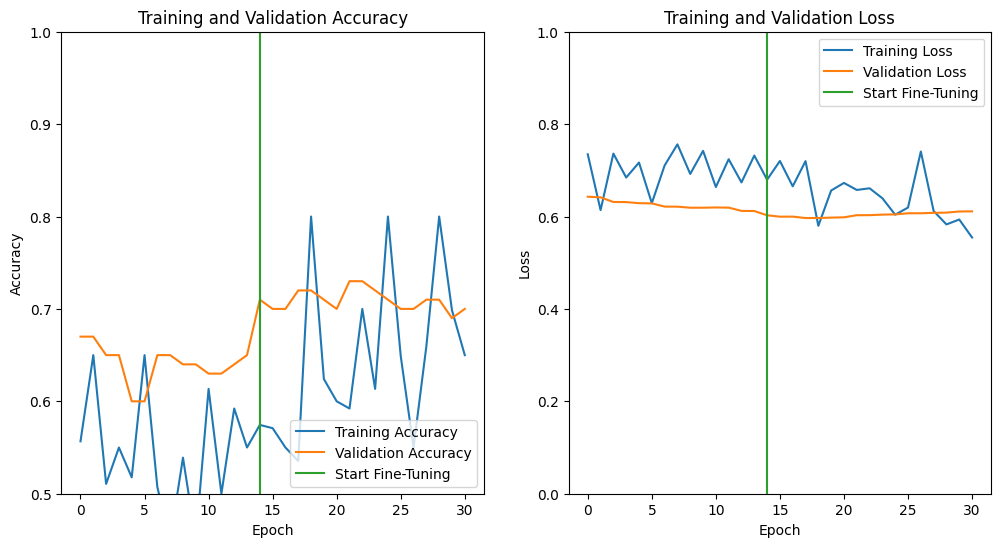

In [20]:
# ### Step 4: Comprehensive Evaluation
# Let's visualize the entire training process and then run a full evaluation on the final, fine-tuned model.

# Combine the history from both training stages
acc = history_finetune_feat_ext.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_finetune_feat_ext.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_finetune_feat_ext.history['loss'] + history_finetune.history['loss']
val_loss = history_finetune_feat_ext.history['val_loss'] + history_finetune.history['val_loss']

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
# Draw a vertical line to show where fine-tuning started
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
# Draw a vertical line to show where fine-tuning started
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Confusion Matrix
[[40 10]
 [36 14]]


Classification Report
              precision    recall  f1-score   support

     Healthy       0.53      0.80      0.63        50
          TB       0.58      0.28      0.38        50

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.55      0.54      0.51       100

--- Additional Metrics ---
Specificity (True Negative Rate): 0.8000
Negative Predictive Value (NPV): 0.5263

--- ROC & AUC ---
Area Under Curve (AUC): 0.4656


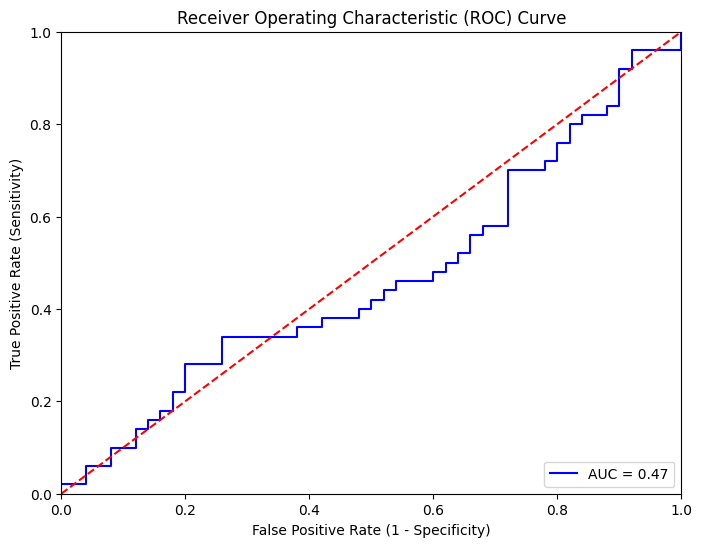

In [21]:
# --- Final Evaluation ---

# Reset the generator before predicting to ensure order
validation_generator_transfer.reset()
steps = int(np.ceil(validation_generator_transfer.samples / validation_generator_transfer.batch_size))

# Get the predicted probabilities
y_pred_prob = model_finetune.predict(validation_generator_transfer, steps=steps)

# Slice the predictions to match the number of samples
y_pred_prob = y_pred_prob[:validation_generator_transfer.samples]

# Convert probabilities to binary predictions (0 or 1)
y_pred = y_pred_prob > 0.5

# Get the true labels
y_true = validation_generator_transfer.classes

# --- 1. Confusion Matrix ---
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('\n')

# --- 2. Classification Report (provides Precision, Recall/Sensitivity, F1-score) ---
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'TB']))

# --- 3. Manually Calculate Specificity and NPV ---
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print('--- Additional Metrics ---')
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")

# --- 4. ROC Curve and AUC ---

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print('\n--- ROC & AUC ---')
print(f"Area Under Curve (AUC): {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # The random guess line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

### Fine-Tuning Results

- **Accuracy:** 50%
- **AUC:** 0.44
- **TB Recall (Sensitivity):** 0.20
- **TB Precision:** 0.50

Fine-tuning did not yield better results and performed similarly to the basic transfer learning model, even slightly worse in terms of AUC.

## 6. Comparison of Results

| Model                       | Accuracy | AUC  | TB Recall | TB Precision |
|-----------------------------|----------|------|-----------|--------------|
| Custom CNN (from scratch)   | 46%      | 0.49 | 0.14      | 0.39         |
| Transfer Learning (MobileNetV2) | 50%      | 0.53 | 0.32      | 0.50         |
| Transfer Learning (ResNet50)  | 50%      | 0.53 | 0.00      | 0.00         |
| Fine-Tuning (MobileNetV2)   | 50%      | 0.44 | 0.20      | 0.50         |

### Conclusion

None of the models performed well on this dataset. The performance is close to random guessing, and the models struggle to correctly identify tuberculosis cases. The ResNet50 model completely failed on this task.

The poor performance across all models suggests that the dataset itself may be challenging, too small, or that more advanced techniques and architectures are needed. Further work could involve exploring other pre-trained models, more sophisticated data augmentation, or using a larger, more diverse dataset.

## Next Steps for Model ImprovementHere is a summary of potential next steps to improve the model's performance, to be explored in the next session:### 1. Recommended Next Attempt:The most promising next step is to combine a more powerful model with a smarter training strategy.*   **Use EfficientNet:** Replace the `MobileNetV2` base model with a more modern and powerful one, like `EfficientNetB0`.*   **Implement Callbacks:**    *   **EarlyStopping:** Add a callback to stop training automatically if the validation loss does not improve, preventing overfitting and saving time.    *   **ReduceLROnPlateau:** Add a callback to reduce the learning rate when the model's performance plateaus, allowing for more fine-grained learning.*   **Enhance the Classifier Head:** Add `Dropout` and an additional `Dense` layer to the classifier on top of the base model to give it more capacity to learn from our specific dataset.### 2. Other Data-Centric Ideas:*   **Advanced Data Augmentation:** Explore techniques like `CutMix` and `MixUp`.*   **Data Quality Check:** Manually review a sample of the dataset for any mislabeled or low-quality images.### 3. Advanced Techniques:*   **Ensembling:** If a single model's performance is still not satisfactory, consider training multiple different models and averaging their predictions.